In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(1)
n = 20
pbar = np.ones((n,1))*.03 + np.r_[np.random.rand(n-1,1), np.zeros((1,1))]*.12;
S = np.random.randn(n, n); S = np.asmatrix(S)
S = S.T*S
S = S/max(np.abs(np.diag(S)))*.2
S[:, -1] = np.zeros((n, 1))
S[-1, :] = np.zeros((n, 1)).T
x_unif = np.ones((n, 1))/n; x_unit = np.asmatrix(x_unif)

In [ ]:
min_risk_uniform_portfolio = np.sqrt(x_unif.T @ S @ x_unif)[0,0]
print(f'Risk of uniform portfolio: {min_risk_uniform_portfolio}')

x = cp.Variable((n, 1))

obj = cp.Minimize(cp.quad_form(x, S))
constraints = [
    pbar.T @ x == pbar.T @ x_unif,
    cp.sum(x) == 1
]

#a) No constraints
prob = cp.Problem(obj, constraints)
min_risk_no_constraints = np.sqrt(prob.solve())
print(f'Min variance portfolio with no constraints: {min_risk_no_constraints}')

#b) Long only
prob = cp.Problem(obj, constraints + [x >= 0])
min_risk_long_only = np.sqrt(prob.solve())
print(f'Min variance long only portfolio: {min_risk_long_only}')

#c) Limit on short
prob = cp.Problem(obj, constraints + [cp.sum(cp.neg(x)) <= 0.5])
min_risk_limit_on_short = np.sqrt(prob.solve())
print(f'Min variance portfolio with limit on short: {min_risk_limit_on_short}')

Risk of uniform portfolio: 0.06661078122826401
Min variance portfolio with no constraints: 0.009032182720195034
Min variance long only portfolio: 0.03950047401406196
Min variance portfolio with limit on short: 0.01497349698730887


In [ ]:
def long_risk_portfolio(mus):

  risks = []
  rets = []
  
  mu = cp.Parameter(nonneg=True)

  for mu_val in mus:
    mu.value = mu_val

    x = cp.Variable((n, 1))
    obj = cp.Maximize(pbar.T @ x - mu * cp.quad_form(x, S))
    constraints = [
        cp.sum(x) == 1, 
        x >= 0
    ]

    cp.Problem(obj, constraints).solve()
  
    x = x.value
    risk = np.sqrt((x.T @ S @ x)[0, 0])
    ret = (pbar.T @ x)[0, 0]
    
    risks.append(risk)
    rets.append(ret)

  return np.array(risks), np.array(rets)
    

def short_risk_portfolio(mus):

  risks = []
  rets = []
  
  mu = cp.Parameter(nonneg=True)

  for mu_val in mus:
    mu.value = mu_val
  
    x = cp.Variable((n, 1))
    obj = cp.Maximize(pbar.T @ x - mu * cp.quad_form(x, S))
    constraints = [
        cp.sum(x) == 1, 
        cp.sum(cp.neg(x)) <= 0.5
    ]

    cp.Problem(obj, constraints).solve()
    
    x = x.value
    risk = np.sqrt((x.T @ S @ x)[0, 0])
    ret = (pbar.T @ x)[0, 0]
    
    risks.append(risk)
    rets.append(ret)

  return np.array(risks), np.array(rets)


mus = np.logspace(-1, 4, 128)
long_risks, long_rets = long_risk_portfolio(mus)
short_risks, short_rets = short_risk_portfolio(mus)

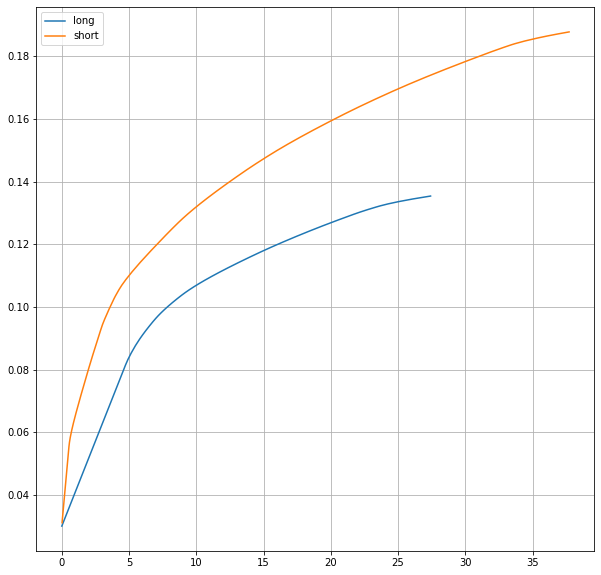

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(long_risks*100, long_rets, label='long')
plt.plot(short_risks*100, short_rets, label='short')
plt.legend()
plt.grid()